In [0]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


In [0]:
# MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1] # = 784
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
input_shape = (original_dim, )
intermediate_dim = 256
batch_size = 128
latent_dim = 2
epochs = 10

In [0]:
# AE の実装
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z = Dense(latent_dim, activation='relu')(x)

encoder = Model(inputs, z, name='encoder')

latent_inputs = Input(shape=(latent_dim,), name='z')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')

z_output = encoder(inputs)
outputs = decoder(z_output)

ae = Model(inputs, outputs, name='ae_mlp')

In [0]:
data = (x_test, y_test)

# Reconstruction Loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

ae_loss = K.mean(reconstruction_loss)
ae.add_loss(ae_loss)
ae.compile(optimizer='adam')
ae.summary()
print(x_train.shape, x_test.shape)
ae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))


Model: "ae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              (None, 2)                 201474    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 403,730
Trainable params: 403,730
Non-trainable params: 0
_________________________________________________________________
(60000, 784) (10000, 784)



Train on 60000 samples, validate on 10000 samples
Epoch 1/10





60000/60000 [==============================] - 11s 180us/step - loss: 49.8489 - val_loss: 42.3867
Epoch 2/10
60000/60000 [==============================] - 2s 25us/step - loss: 41.1924 - val_loss: 39.8935
Epoch 3/10
60000/60000 [==============================] - 1s 25us/step - loss: 39.2

In [0]:
import matplotlib.cm as cm

def plot_results_ae(encoder,
                 decoder,
                 x_test,
                 y_test,
                 batch_size=128,
                 model_name="vae_mnist"):
      
    z_mean = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    cmap=cm.tab10
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=cmap(y_test))
    m = cm.ScalarMappable(cmap=cmap)
    m.set_array(y_test)

    plt.colorbar(m)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    
    #
    # (-40, -40) から (40, 40) までを30x30分割してプロットする
    #
    n = 50
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-40, 40, n)
    grid_y = np.linspace(-40, 40, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='Greys_r')
    #plt.savefig(filename)
    plt.show()

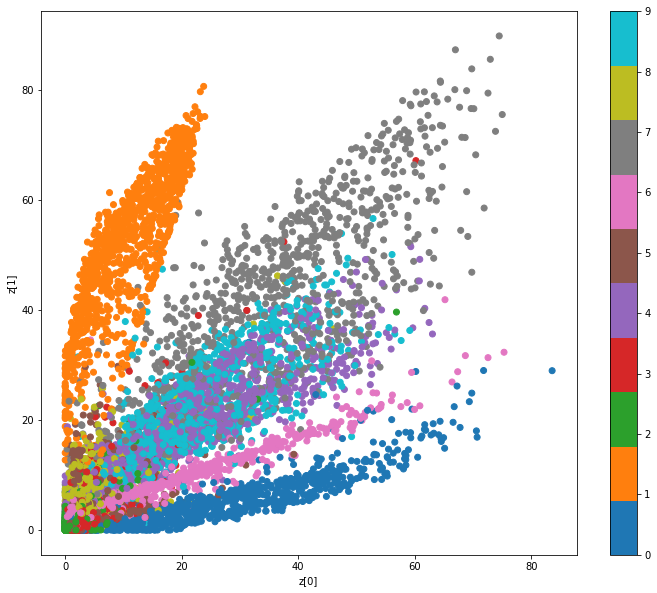

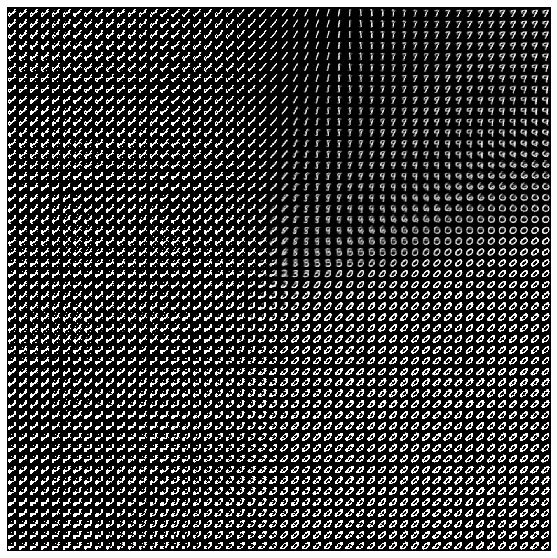

In [0]:

plot_results_ae(encoder,
                 decoder,
                 x_test,
                 y_test,
                 batch_size=batch_size,
                 model_name="vae_mlp")

# VAE


In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:
# VAE の実装
# 入力層　→　平均 & 分散
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# reparameterization trick 用の層を追加
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# VAE 全体をモデル化する
z_output = encoder(inputs)[2]
outputs = decoder(z_output)
vae = Model(inputs, outputs, name='vae_mlp')


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 256)          200960      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         dense_5[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         dense_5[0][0]                    
___________________________________________________________________________________________

In [0]:
data = (x_test, y_test)

# Reconstruction Loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

# Kullback-Leibler Loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 39us/step - loss: 54.2552 - val_loss: 44.3264
Epoch 2/10
60000/60000 [==============================] - 2s 32us/step - loss: 43.6032 - val_loss: 42.7370
Epoch 3/10
60000/60000 [==============================] - 2s 33us/step - loss: 42.5585 - val_loss: 42.0191
Epoch 4/10
6

In [0]:
import matplotlib.cm as cm

def plot_results(encoder,
                 decoder,
                 x_test,
                 y_test,
                 batch_size=128,
                 model_name="vae_mnist"):
      
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    cmap=cm.tab10
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=cmap(y_test))
    m = cm.ScalarMappable(cmap=cmap)
    m.set_array(y_test)

    plt.colorbar(m)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    
    #
    # (-4, -4) から (4, 4) までを30x30分割してプロットする
    #
    n = 50
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='Greys_r')
    #plt.savefig(filename)
    plt.show()

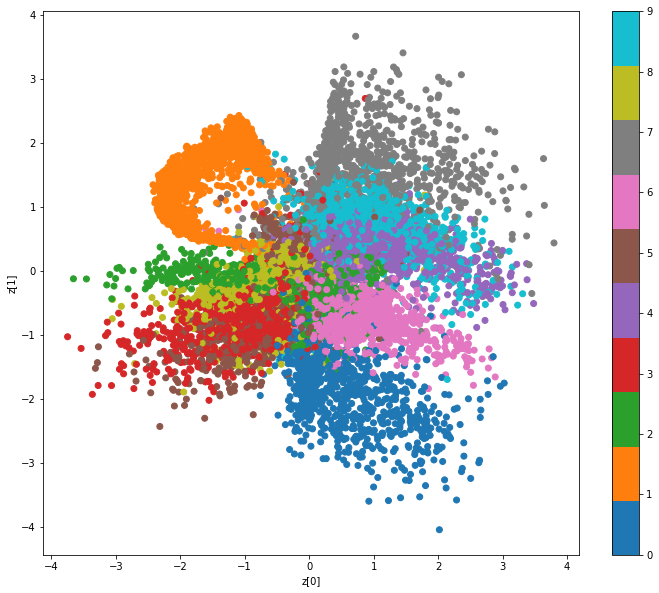

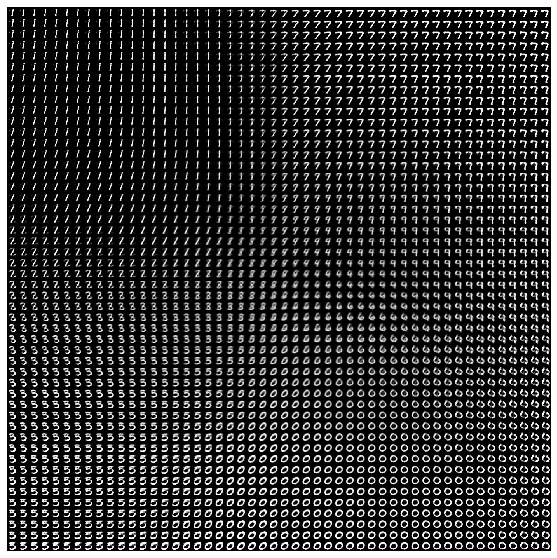

In [0]:
plot_results(encoder,
                 decoder,
                 x_test,
                 y_test,
                 batch_size=batch_size,
                 model_name="vae_mlp")